# Inference

In [1]:
import os
import json
import time
import datetime
import numpy as np
import tensorflow as tf
import tensorflow_text as tf_text
import matplotlib.pyplot as plt
from data_utils import DataManager, load_sentencepiece_model
from model import Transformer
from _inference_model import TransformerLayer
from utils import create_masks

%load_ext autoreload
%autoreload 2

## Load model from weights

In [2]:
# Load model configuration
with open('trained_models/model_config.json', 'r') as file:
    configs = json.loads(file.read())

In [3]:
# Load the model from weights
model = Transformer(**configs)
inp = tf.random.uniform((1,4), 0, 10, tf.int32)
_ = model(inp, inp, False, None, None, None)
model.load_weights('trained_models/translator_weights')

## Load tokenizers

In [6]:
# Load the tokenizers
inp_tokenizer = load_sentencepiece_model('tokenizers/modern2k.model', 1)
tar_tokenizer = load_sentencepiece_model('tokenizers/original2k.model', 1)

# Eager mode inference. 

You do not need to save model or use tf.function for this. The model must be loaded from weights.

In [23]:
def predict(input_sentence, inp_tokenizer, model, temp=1., max_length=100):
    inp = tf.concat([[1], inp_tokenizer.tokenize(input_sentence), [2]], 0)[tf.newaxis, :]
    tar = tf.constant([1], dtype=inp.dtype)[tf.newaxis, :]
    for i in range(max_length):
        enc_mask, comb_mask, dec_mask = create_masks(inp, tar)
        preds, weights = model(inp, tar, training=False, enc_padding_mask=enc_mask,
                           look_ahead_mask=comb_mask, dec_padding_mask=dec_mask)
        next_token = tf.cast(tf.random.categorical(preds[:,-1]/temp, 1), tar.dtype)
        if tf.reduce_all(tf.equal(next_token, 2)):
            break
        tar = tf.concat([tar, next_token], axis=1)
    return tar, weights

In [232]:
def plot_attn_weights(inp_text, tar_seq, attn_weights,
                      inp_tokenizer, tar_tokenizer):
    fig = plt.figure(figsize=(8, 8))

    inp_seq = inp_tokenizer.tokenize(inp_text)
    tar_seq = tf.squeeze(tar_seq, 0)
    inp_seq = [x.numpy().decode() for x in inp_tokenizer.id_to_string(inp_seq)]
    tar_seq = [x.numpy().decode() for x in tar_tokenizer.id_to_string(tar_seq)]
    attn_weights = tf.squeeze(attn_weights, 0)
    for head in range(attn_weights.shape[0]):
        ax = fig.add_subplot(2, 2, head+1)
        ax.matshow(attn_weights[head], cmap='viridis')
        fontdict = {'fontsize': 14}
        ax.set_xticks(range(len(inp_seq)+2))
        ax.set_yticks(range(len(tar_seq)))
        ax.set_xticklabels(['<sos>']+inp_seq+['<eos>'], fontdict=fontdict,
                           rotation=45)
        ax.set_yticklabels(tar_seq[1:]+['<eos>'], fontdict=fontdict)
        ax.set_xlabel('Head {}'.format(head+1))

    plt.tight_layout()
#     plt.savefig('insult')
    plt.show()


In [47]:
inp = 'where are you romeo?'
inp = 'He is an awful person.'
res, attn_weights = predict(inp, inp_tokenizer, model, temp=1.0, max_length=100)
print(tar_tokenizer.detokenize(res))

tf.Tensor([b'he is an wretched man.'], shape=(1,), dtype=string)


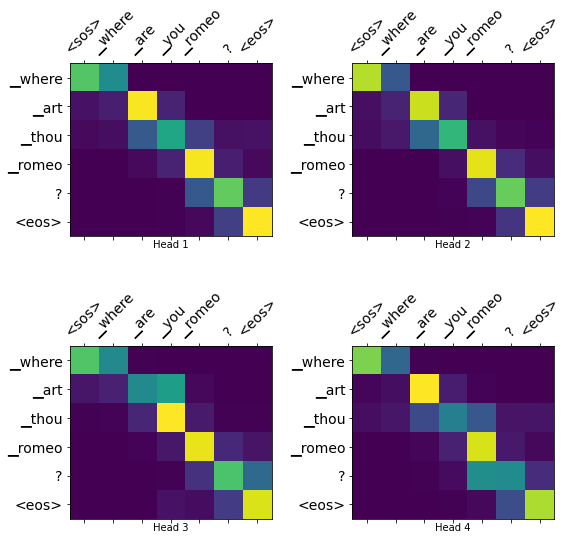

In [211]:
plot_attn_weights(inp, res, attn_weights['decoder_layer4_block2'], inp_tokenizer, tar_tokenizer)

## Eager beam search

In [48]:
def eager_beam_search(input_text, inp_tokenizer, model, K=5, maxlen=32):
    x = tf.concat([[1], inp_tokenizer.tokenize(input_text), [2]], 0)
    x = tf.repeat(x[tf.newaxis, :], K, axis=0)
    y = tf.ones((K, 1), dtype=x.dtype)
#     y = tf.concat([y, tf.zeros((K, MAX_LENGTH-1), dtype=inp.dtype)], 1)
    flattened_row_ids = tf.repeat(tf.range(K), K)
    prior = tf.constant([0.]+[-1e5]*(K-1)) # mask out the lower entries to start
    eos_mask = tf.zeros((K,1), dtype=tf.float32)
    new_tokens = tf.constant([[0]])

    for i in range(maxlen):
#         print(i)
        if tf.not_equal(new_tokens[0], 2):
            logits, _ = model(x, y, False, None, None, None)
            log_probs = tf.nn.log_softmax(logits[:, -1, :])
            log_probs += tf.reshape(prior, (-1,1))
            log_probs += eos_mask
            
            prob_matrix, token_matrix = tf.math.top_k(log_probs, k=K)
            prob_list = tf.reshape(prob_matrix, (1,-1) )
            token_list = tf.reshape(token_matrix, (1,-1) )

            prior, list_ids = tf.math.top_k(prob_list, k=K)
            row_id = tf.gather(flattened_row_ids, tf.squeeze(list_ids))
            new_tokens = tf.gather(token_list[0], list_ids[0])
            eos_mask = -1e5*tf.reshape(
                tf.cast(tf.equal(new_tokens, 2), tf.float32), (-1,1))

            y = tf.gather(y, row_id)
            y = tf.concat([y, new_tokens[:, tf.newaxis]], axis=1)
#             y = tf.concat([y[:,:i+1], new_tokens[:,tf.newaxis], y[:,i+2:]], axis=1)
        else:
            break
    return y, prior[0]

In [49]:
inp = 'I don\'t know if she still love me.'
res, probs = eager_beam_search(inp, inp_tokenizer, model)
for sent, prob in zip(res, probs):
    sent = tar_tokenizer.detokenize(sent).numpy().decode()
    print(f"Translation: {sent}\tProb.: {prob:.2f}")

Translation: i know not, if she love me.	Prob.: -3.80
Translation: i know not, if she be love me.	Prob.: -3.96
Translation: i know not if she be love me.	Prob.: -5.45
Translation: i know not, if she be love.	Prob.: -6.72
Translation: i know not, if she love me well.	Prob.: -7.40


In [54]:
inp = 'He is a bad and mean person.'
res, probs = eager_beam_search(inp, inp_tokenizer, model)
for sent, prob in zip(res, probs):
    sent = tar_tokenizer.detokenize(sent).numpy().decode()
    print(f"Translation: {sent}\tProb.: {prob:.2f}")

Translation: he is very well.	Prob.: -5.14
Translation: he is very well, and	Prob.: -6.39
Translation: he is a man and mean	Prob.: -6.61
Translation: he is a noble and mean	Prob.: -6.73
Translation: he is very well and mean	Prob.: -6.95


# Serving: static computational graph saving

### Demote the Transformer model into a Transformer layer

If we don't do this, it will throw errors that we are calling too many positional arguments. Models can only call one input, but layers have much more freedom.

It's literally identical code to the model. We just inherit from a different class.

In [ ]:
from model import Encoder, Decoder
class TransformerLayer(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, d_ffn,
                 input_vocab_size, target_vocab_size, pe_input,
                 pe_target, p_drop=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, d_ffn,
                              input_vocab_size, pe_input, p_drop)
        self.decoder = Decoder(num_layers, d_model, num_heads, d_ffn,
                              target_vocab_size, pe_target, p_drop)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask,
            dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)
        dec_output, attn_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)
        return final_output, attn_weights

### Load model weights into the layer

In [119]:
layer = TransformerLayer(**configs)
tmp = tf.random.uniform((1,4), 0, 10, tf.int32)
layer(tmp, tmp, False, None, None, None)
layer.set_weights(model.get_weights())

## Base model

To run the base model, we run the computation graph over the same sized inputs/outputs everytime. This means that the inputs are all padded to max length, and the target begins as  matrix (K, max length) of all zeros, with the first column all ones (for the start token).

This way, the function gets the same tensors every time. It is more memory wasteful, but that's fine since the arrays are super tiny compared to the model size. It is also computationally wasteful for small translations, but will be much more efficient as the sequence length approaches max_length.

The tensorshape parameters need to be hardcoded, so they are stored in global variables.

### The fit_to_length function can't be serialized (it takes variable input), but needs to be run as a preprocessing step!

In [85]:
def add_padding(x, maxlen):
    n = tf.maximum(maxlen-tf.size(x), 0)
    return tf.pad(x, [(0, n)])

def fit_to_length(x, maxlen):
    x = tf.concat([[1], x, [2]], 0)
    x = x[:maxlen]
    x = add_padding(x, maxlen)
    return x

### Mask functions. these will go into the computation graph

In [68]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask[tf.newaxis, tf.newaxis, :, :]  # (1, 1, seq_len, seq_len)

def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    return enc_padding_mask, combined_mask, dec_padding_mask 

### Build the model

Remember, hardcode length and K.

In [94]:
MAX_LENGTH = 32
K = 5

class Translator(tf.keras.Model):
    def __init__(self, transformer, **kwargs):
        super().__init__(**kwargs)
        self.transformer = transformer

    @tf.function(input_signature=[tf.TensorSpec(shape=(MAX_LENGTH,), dtype=tf.int32)])
    def call(self, x):
        x = tf.repeat(x[tf.newaxis, :], K, axis=0)
        y = tf.ones((K, 1), dtype=x.dtype)
        y = tf.concat([y, tf.ones((K, MAX_LENGTH-1), dtype=x.dtype)], 1)
        flattened_row_ids = tf.repeat(tf.range(K), K)
        prior = tf.constant([0.]+[-1e5]*(K-1)) # mask out the lower entries to start
        eos_mask = tf.zeros((K,1), dtype=tf.float32)
        new_tokens = tf.constant([[0]])

        for i in range(MAX_LENGTH):
            if tf.not_equal(new_tokens[0], 2):
                logits, _ = self.transformer(x, y, False, *create_masks(x, y))
                log_probs = tf.nn.log_softmax(logits[:, i, :])
                log_probs += tf.reshape(prior, (-1,1))
                log_probs += eos_mask

                prob_matrix, token_matrix = tf.math.top_k(log_probs, k=K)
                prob_list = tf.reshape(prob_matrix, (1,-1) )
                token_list = tf.reshape(token_matrix, (1,-1) )

                prior, list_ids = tf.math.top_k(prob_list, k=K)
                row_id = tf.gather(flattened_row_ids, tf.squeeze(list_ids))
                new_tokens = tf.gather(token_list[0], list_ids[0])
                eos_mask = -1e5*tf.reshape(
                    tf.cast(tf.equal(new_tokens, 2), tf.float32), (-1,1))

                y = tf.gather(y, row_id)
                y = tf.concat([y[:,:i], new_tokens[:,tf.newaxis], y[:,i+1:]], axis=1)
            else:
                continue
        return y, prior[0]

## Save the computation graph with the right weights

In [234]:
layer = TransformerLayer(**configs)
tmp = tf.random.uniform((1,4), 0, 10, tf.int32)
layer(tmp, tmp, False, None, None, None)
layer.set_weights(model.get_weights())

translator = Translator(layer)
translator.save('modelK5Len32-0001/')

In [72]:
# signatures = {'serving_default': translator.call,
#               'tokenized_input': translator.call.get_concrete_function(
#                   tf.TensorSpec((MAX_LENGTH,), tf.int32))
#              }

In [92]:
# tf.saved_model.save(translator, 'modelK5Len32-0001', signatures=signatures)

In [74]:
test_model = tf.saved_model.load('modelK5Len32-0001/')

In [86]:
x = "When in the course of human events, it becomes necessary for one people to."
x = inp_tokenizer.tokenize(x)
x = fit_to_length(x, MAX_LENGTH)
tar_tokenizer.detokenize(test_model.call(x)[0])

## Minimum Bayes Risk prediction

Here we compute a batch of randomly sampled translations. We then use the python difflib sequence matcher to compare all pairs of sequences. We then rank candidates based on which ones are closest to the "mean" i.e. are most similar to all other translations.

The batch prediction can easily run in graph mode, so we from the start we will pad our translations.

Again, we will need to input sequences all of length MAX_LENGTH, padded or truncated if necessary.

In [116]:
def batch_random_predict(input_text, inp_tokenizer, model,
                         temp=1.0, n_samples=16, max_length=16):
    
    inp = tf.concat([[1], inp_tokenizer.tokenize(input_text), [2]], 0)
    inp = tf.repeat(inp[tf.newaxis, :], n_samples, axis=0)

    tar = tf.ones((n_samples,1), dtype=inp.dtype)
    mask = tf.ones((n_samples, 1), dtype=tf.bool) # for ended sentences

    for _ in range(max_length):
        enc_mask, comb_mask, dec_mask = create_masks(inp, tar)
        logits, weights = model(inp, tar, training=False, 
                               enc_padding_mask=enc_mask,
                               look_ahead_mask=comb_mask,
                               dec_padding_mask=dec_mask)

        logits = logits[:,-1,:]/tf.cast(temp, tf.float32)
        next_tokens = tf.cast(tf.random.categorical(logits, 1), inp.dtype)
        
        # replace any already finished sentences with padding 4 next token
        next_tokens = tf.where(mask, next_tokens, 0)
        
        # update mask. to stay true, it must:
        # 1) already be true
        # 2) not currently be an end of sentence token
        mask = tf.logical_and(mask, tf.not_equal(next_tokens, 2))
        tar = tf.concat([tar, next_tokens], axis=1)
        if not tf.reduce_any(mask):
            break
    return tar, weights

In [131]:
translations, weights = batch_random_predict('where are you romeo?', inp_tokenizer, model)

In [140]:
from difflib import SequenceMatcher
def sort_by_most_similar(arr):
    """ For each row, it computes the mean similarity score with all other
    rows and stores it in sims. Then it chooses the row with highest mean
    and returns the array at that index."""
    sims = []
    if tf.is_tensor(arr):
        arr = arr.numpy()
    N = arr.shape[0]
    for i in range(N):
        sims.append(-np.mean([SequenceMatcher(a=arr[i], b=arr[j]).ratio() 
                  for j in range(N) if j!=i]))
    return np.argsort(sims)

In [207]:
def minimum_bayes_risk_predict(input_text, inp_tokenizer, model,
                         temp=1.0, n_samples=16, max_length=16):
    translations, weights = batch_random_predict(input_text, inp_tokenizer, model,
                                                 temp, n_samples, max_length)
    if tf.is_tensor(translations):
        translations = translations.numpy()
    permuatation = sort_by_most_similar(translations)
    translations = translations[permuatation]
    weights = {k: tf.gather(v, permuatation) for k,v in weights.items()}
    return translations, weights

### Shakespearian insults

The most fun use of the batch prediction is to generate novel translations. Below we type in an insult, and see how it may sound in shakespearian. 

In [257]:
text = "you are stupid and evil."
translations, weights = minimum_bayes_risk_predict(
    text, inp_tokenizer, model, n_samples=16, temp=0.9, max_length=16)

In [258]:
tar_tokenizer.detokenize(translations)

<tf.Tensor: shape=(16,), dtype=string, numpy=
array([b'thou art a foolish and liaring.',
       b'thou art a foolish and libeck.',
       b'thou art a foolish creature, and change.',
       b'thou art a foolish and dark.', b'thou art limine and lit.',
       b'thou art false and liaring.',
       b'thou art a foolish, and trasemated.',
       b'a foolish deed, thou lip and litio.',
       b'a proper wicked and train.',
       b'thou art unarm lie and lity thee.',
       b'you lies a wickedness and lifty.',
       b'thou art lifort and unnatural in a foolishness.',
       b'you are foolish and liar and lit and foolish.',
       b'a foolish delential and lingally.',
       b'you charity, and foolish and bitter.',
       b'thou art a vileness, and thou art a wicked man.'], dtype=object)>

tf.Tensor(b'thou art false and liaring.', shape=(), dtype=string)


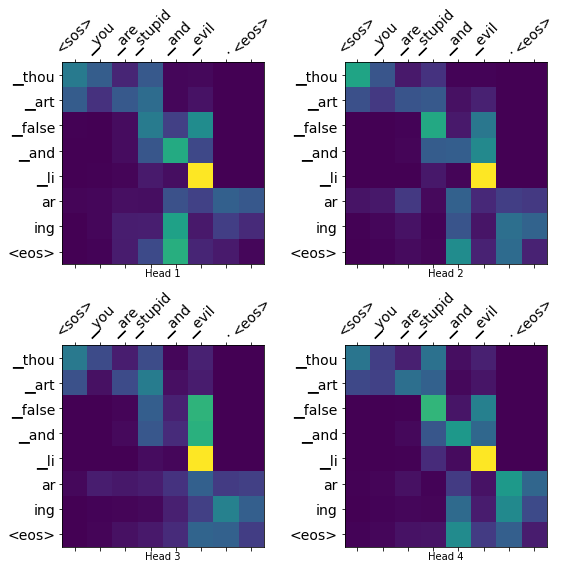

In [259]:
i = 5
print(tar_tokenizer.detokenize(translations)[i])
plot_attn_weights(text, translations[i:i+1,:8], weights['decoder_layer4_block2'][i:i+1,:,:8],
                 inp_tokenizer, tar_tokenizer)

### discarded stuff
the difflib library can't be run in graph mode. But, we can instead vectorize sequences into one hot bins, then try to find which row is closest to the mean

this doesn't work that well, it tends to favor repetitive semantically nonsensical translations.

In [ ]:
CatEncoder = tf.keras.layers.experimental.preprocessing.CategoryEncoding(
      max_tokens=int(tar_tokenizer.vocab_size()), output_mode="count", sparse=True)

@tf.function
def similarity_ranked_indices(arr):
    A = CatEncoder(arr)
    B = tf.reshape(tf.sparse.reduce_sum(A, axis=0), (-1,1))
    scores = tf.squeeze(tf.sparse.sparse_dense_matmul(A, B))
    idxs = tf.argsort(scores, direction='DESCENDING')
    return idxs

In [ ]:
class RootDecaySchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, max_lr, warmup_steps, **kwargs):
        super().__init__(**kwargs)
        self.max_lr = max_lr
        self.warmup_steps = warmup_steps
    def __call__(self, step):
        linear = self.max_lr*(step/self.warmup_steps)
        decay_steps = tf.math.maximum(step-self.warmup_steps, 1e-7)
        fall = self.max_lr*0.1**(decay_steps/5000.)
        return tf.math.minimum(linear, fall)